# Imports

In [2]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

In [3]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import optuna
import utils.h5_utils as h5
import random

from pathlib import Path
from npyx.feat import filter_df
from sklearn import preprocessing
from tqdm.auto import tqdm, trange
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

npyx version 2.5.2 imported.


In [4]:
# get relative data folder
PATH = os.path.dirname(os.path.abspath(''))
data_folder = PATH + '/data'
DATA_PATH = data_folder + ("/Aug-09-2022_all_features.csv")


In [5]:
SEED = 1234
h5.set_seed(SEED)

Random seed 1234 has been set.


1234

In [6]:
df = pd.read_csv(DATA_PATH, index_col=0)

In [7]:
def filter_df(df:pd.DataFrame):
    """
    Filters out datapoints with unusable temporal features.
    """
    features_only = df.iloc[:, 2:]
    bad_idx = []
    for i, row in features_only.iterrows():
        value, count = np.unique(row.to_numpy(), return_counts=True)
        zeros = count[value == 0]
        if  zeros.size > 0 and zeros > 5:
            bad_idx.append(i)
    keep = [i for i in range(len(df)) if i not in bad_idx]
    return df.iloc[keep]

In [8]:
def generate_train_and_labels(df: pd.DataFrame, info_idx = [0, 1 , 2 ,18]):
    info = df.iloc[:, info_idx]
    features = df.iloc[:, ~np.isin(np.arange(len(df.columns)), info_idx)]
    return features.copy(), info.iloc[:, 0].copy()

In [15]:
discard_idx = [0, 1 , 2 ,18]+list(range(19, len(df.columns)))
X, y = generate_train_and_labels(filter_df(df), info_idx = discard_idx)

In [33]:
X

,mfr,mifr,med_isi,mode_isi,prct5ISI,entropy,CV2_mean,CV2_median,CV,IR,Lv,LvR,LcV,SI,SKW
0,150.732293,168.887927,0.005733,0.005,0.004200,6.195362,0.271033,0.174497,0.430411,0.281221,0.108944,20.697672,-0.065886,0.008628,2.452598
1,169.619210,181.015329,0.005400,0.005,0.004200,6.239865,0.200738,0.140468,0.311867,0.204771,0.058696,13.163842,-0.049011,0.004487,2.519771
2,67.873494,77.598552,0.013433,0.010,0.007767,7.095214,0.360792,0.308903,0.388699,0.373602,0.149873,15.993906,-0.085606,0.011696,1.080671
3,62.177479,70.185859,0.015133,0.012,0.008433,7.201189,0.336333,0.289767,0.352702,0.346607,0.130289,13.144798,-0.083250,0.010069,0.792209
4,70.140206,74.991100,0.013900,0.012,0.008767,7.322565,0.250031,0.214112,0.256132,0.254155,0.072520,8.310697,-0.060448,0.005441,0.442617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,4.733793,15.349060,0.126367,0.015,0.017700,6.422393,0.888580,0.860718,1.074950,1.109872,0.806791,10.839819,-0.531631,0.088925,1.814136
80,28.042857,45.032721,0.029367,0.008,0.008767,7.026437,0.710721,0.676760,0.683381,0.804640,0.528052,27.394340,-0.196347,0.048537,1.142575
81,4.251309,26.590133,0.044967,0.026,0.016267,1.389866,0.708923,0.669056,5.183696,0.877025,0.555724,13.528616,-0.355147,0.065489,7.830272
82,4.364287,14.242719,0.131433,0.028,0.019128,6.332204,0.848762,0.812496,1.119163,1.038458,0.740980,10.126541,-0.549045,0.079087,1.958817


In [18]:
# Converting text labels to numbers
LABELLING = {'PkC_cs': 5, 'PkC_ss': 4, 'MFB':3, 'MLI':2, 'GoC':1, 'GrC':0}

# To do the inverse
CORRESPONDENCE = {5: 'PkC_cs', 4: 'PkC_ss', 3 : 'MFB', 2: 'MLI', 1:'GoC', 0:'GrC'}

y.replace(to_replace = LABELLING, inplace = True)

In [19]:
y.value_counts()

1    25
4    21
5    11
3     9
0     6
2     5
Name: label, dtype: int64

# Random forest

In [20]:
best_params = optuna.load_study("random-forest-feat-eng", f"sqlite:///{PATH}/random-forest-feat-eng.db").best_params

In [21]:
N_LOOS = 50

In [22]:
kfold = LeaveOneOut()

f1_scores = []
confusions_list = []

for loo in tqdm(range(N_LOOS), position = 0, leave = True, desc = "Random Forest runs"):
    
    train_accuracies = []
    true_targets = []
    model_pred = []
    dummy_pred = []
    seed = np.random.choice(2**32)
    for fold, (train_idx, val_idx) in tqdm(
        enumerate(kfold.split(X, y)),
        leave=False,
        position=1,
        desc="Cross-validating",
        total=len(X),
    ):

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[val_idx]
        y_test = y.iloc[val_idx]

        oversample = RandomOverSampler(random_state=seed)

        X_big, y_big = oversample.fit_resample(X_train, y_train)

        model = RandomForestClassifier(**best_params, random_state=seed)

        # fit the model on the data
        model.fit(X_big, y_big)
        pred = model.predict(X_test)
        train_accuracies.append(model.score(X_train, y_train))

        true_targets.append(y_test)
        model_pred.append(pred)
        

        ####### Now doing something similar with a Dummy Classifier so that we can plot a baseline #########
        dummy = DummyClassifier(strategy="uniform")
        # fit the model on the data
        dummy.fit(X_big, y_big)
        pred = dummy.predict(X_test)

        dummy_pred.append(pred)
        
    confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, 6))
    confusions_list.append(confusion)
    f1 = f1_score(true_targets, model_pred, average='macro')
    f1_scores.append(f1)



mean_train = np.array(train_accuracies).mean()
mean_validation = (np.array(true_targets)==np.array(model_pred)).mean()
mean_dummy = (np.array(true_targets)==np.array(dummy_pred)).mean()
print(
f"Mean train accuracy is {mean_train:.3f} while LOO accuracy is {mean_validation:.3f}"
)
print(f"Dummy LOO accuracy is {mean_dummy:.3f} ")
print(f"Mean LOO f1 score across random forests is {np.array(f1_scores).mean():.3f}")


Random Forest runs:   0%|          | 0/50 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Cross-validating:   0%|          | 0/77 [00:00<?, ?it/s]

Mean train accuracy is 0.949 while LOO accuracy is 0.597
Dummy LOO accuracy is 0.182 
Mean LOO f1 score across random forests is 0.515


In [23]:
X.to_numpy().shape

(77, 15)

In [24]:
max(f1_scores)

0.5559530334724133

In [25]:
np.array(train_accuracies).std()

0.012608247946477595

In [26]:
f1_scores

[0.523678106227324,
 0.553968253968254,
 0.5025979756813765,
 0.5045836516424752,
 0.5519980922419947,
 0.523678106227324,
 0.4729851708575113,
 0.510141548666126,
 0.5228787878787879,
 0.5200523481653135,
 0.5232651116618118,
 0.5424630924630924,
 0.471010471010471,
 0.5340781767252355,
 0.49815610998921533,
 0.5302657215105916,
 0.5402283706631533,
 0.5222384606016319,
 0.49124045888751766,
 0.5021611463471929,
 0.523849104859335,
 0.48482171612606395,
 0.5559530334724133,
 0.4942279942279943,
 0.5089149589833585,
 0.5406141244376539,
 0.5243539224481809,
 0.4736781062273241,
 0.5079523000179634,
 0.5265519547002654,
 0.5035353535353536,
 0.546441520590163,
 0.490169375087687,
 0.5213671818575761,
 0.5335879806468041,
 0.5455873218488401,
 0.5045836516424752,
 0.4929902755394934,
 0.48340421889461327,
 0.5304545454545455,
 0.4839019911029117,
 0.4929902755394934,
 0.5289068643972586,
 0.5185429127289592,
 0.48400890521358525,
 0.5145644607691408,
 0.5374499714122355,
 0.5267617513994

In [27]:
np.array(f1_scores).std()

0.022491197378393876

# Accuracy plots

# Confusion matrix

In [28]:
mean_confusion = confusion_matrix(true_targets, model_pred, labels=np.arange(0, len(LABELLING.keys())))
mean_confusion = mean_confusion / (np.sum(mean_confusion, axis = 0)) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

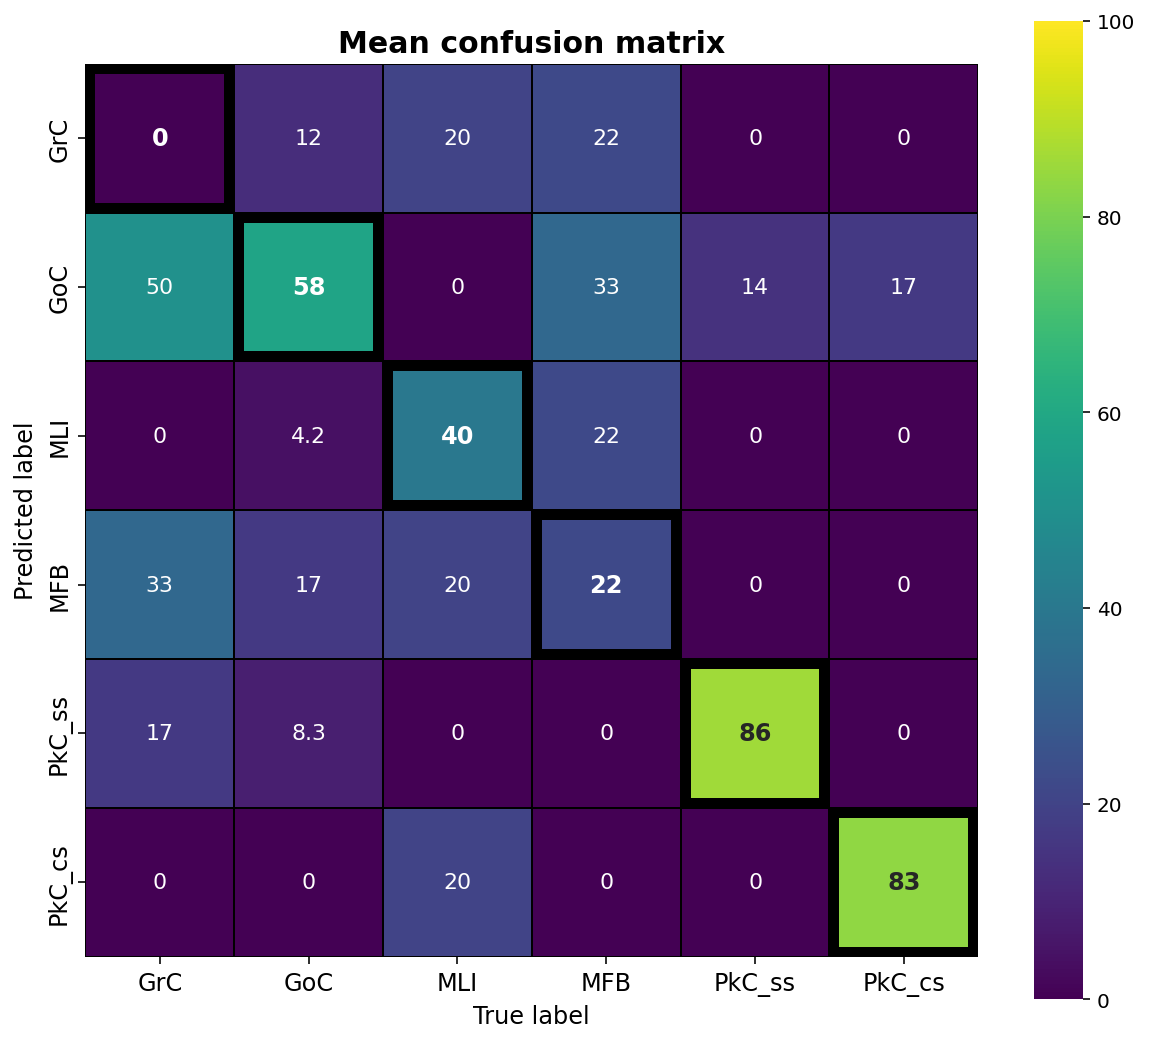

In [29]:
# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=False,
    mask=mask,
    linewidths=10,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    square=True,
    vmin=0,
    vmax=100,
    mask=~mask,
    linewidths=1,
    linecolor="black",
    annot_kws={"fontsize": 11},
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);
